# 1. Install important dependencies

In [1]:
# # Install necessary packages
# !pip install transformers nltk datasets numpy seaborn pandas scikit-learn matplotlib
# pip install accelerate>=0.20.1
!pip install torch
# !pip install accelerate>=0.20.1
# !pip install mlxtend
# !pip install tensorflow

In [2]:
#pip install torch

In [8]:
# !rm ./results_2/tmp-checkpoint-4875/config.json



# 2. Import Dependencies

In [2]:
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# To import the Transformer Models
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification



import torch
from torch.nn.functional import softmax


# to convert to Dataset datatype - the transformers library does not work well with pandas
from datasets import Dataset

import warnings
warnings.filterwarnings("ignore")

### 2.1 Load the dataset

In [4]:
# The dataset does not contain class labels, so we need to explicitly provide it
df=pd.read_csv("train.csv")
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [5]:
df = df.rename(columns={'Class Index':'label'})
df.head()

,label,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


### 2.2 Data statistics

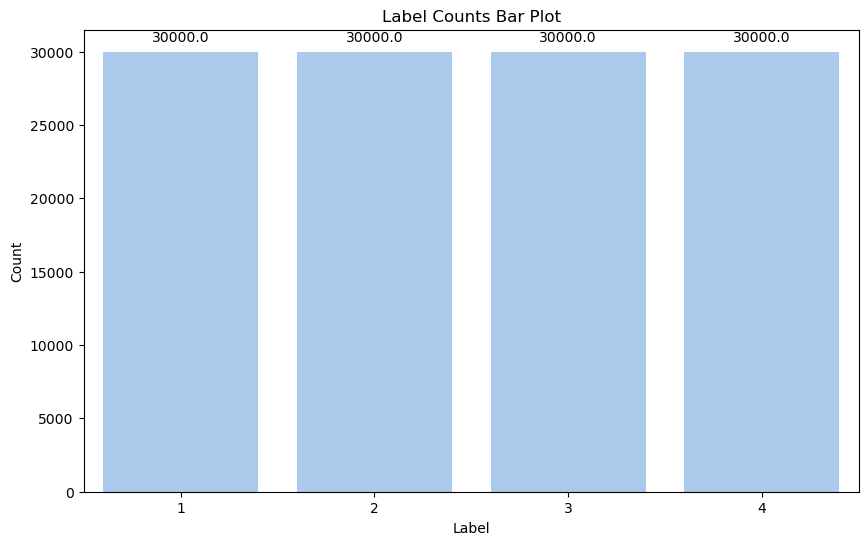

In [6]:
# For train data - checking for unbalanced dataset

value_counts = df['label'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.set_palette("pastel")  # Use a pastel color palette

# Plotting the bar plot
ax = sns.barplot(x=value_counts.index, y=value_counts.values)

# Adding labels and title
ax.set(xlabel='Label', ylabel='Count', title='Label Counts Bar Plot')

# Display the counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

### 2.3 Check for null values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   label        120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


# 3. Data Preprocessing

In [8]:
# concatinating the 'title' and 'description' column
df['text']=(df['Title']+" "+df['Description'])
df.drop(columns=['Title','Description'],axis=1,inplace=True)
df.head()

,label,text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [9]:
# Text before preprocessing - contains symbols like ()\-,.' which is not useful
for i in range(0,4):
    print(df['text'][i])
    print("------------------------------------------")
    print()

Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
------------------------------------------

Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
------------------------------------------

Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the stock market next week during the depth of the\summer doldrums.
------------------------------------------

Iraq Halts Oil Exports from Main Southern Pipeline (Reuters) Reuters - Authorities have halted oil export\flows from the main pipeline in southern Iraq after\intelligence showed a rebel militia could strike\infrastructure, 

### 3.1 Remove Punctuations

In [10]:
import re   # regular expression can be used to remove any punctuation or unnecessary symbols

In [11]:
def remove_punctuations(text):
    text=re.sub(r'[\\-]',' ',text)
    text=re.sub(r'[,.?;:\'(){}!|0-9]','',text)
    return text

# the apply method applies a function along an axis of dataframe
df['text']=df['text'].apply(remove_punctuations)
df['label']=df['label']-1

df.head()

,label,text
0,2,Wall St Bears Claw Back Into the Black Reuters...
1,2,Carlyle Looks Toward Commercial Aerospace Reut...
2,2,Oil and Economy Cloud Stocks Outlook Reuters R...
3,2,Iraq Halts Oil Exports from Main Southern Pipe...
4,2,Oil prices soar to all time record posing new ...


In [12]:
df['text'] = df['text'].apply(lambda x: x.lower())


In [13]:
df['text'][1]   # this is the final preprocessed text

'carlyle looks toward commercial aerospace reuters reuters   private investment firm carlyle group which has a reputation for making well timed and occasionally controversial plays in the defense industry has quietly placed its bets on another part of the market'

### 3.3 Split the data into training and testing sets

In [14]:
from sklearn.model_selection import train_test_split

# since training on the full dataset(120,000 samples) would be take so long, the train size is only taken to be 30%
train_df,test_df=train_test_split(df[['text','label']],train_size=.25,shuffle=True)
test_df=test_df[:10000]

In [15]:
train_df.shape,test_df.shape    # training set has 36000 samples and testing set has 10000 samples

((30000, 2), (10000, 2))

### 3.4 Load a pre-built tokenizer and convert to tokens

In [16]:
# load tokenizer from bert base uncased model available from huggingface.co
model_name='bert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(model_name)

In [17]:
def preprocess_function(examples):
    """
    Tokenizes the given text

    input -> dataset (columns = text, label)
    output -> tokenized dataset (columns = text, label, input, attention)
    """
    return tokenizer(examples["text"], truncation=True)

def pipeline(dataframe):
    """
    Prepares the dataframe so that it can be given to the transformer model
    
    input -> pandas dataframe
    output -> tokenized dataset (columns = text, label, input, attention)
    """    
    # This step isn't mentioned anywhere but is vital as Transformers library only seems to work with this Dataset data type
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)
    tokenized_ds = tokenized_ds.remove_columns('text')
    return tokenized_ds

In [18]:
# create pipeline for training data and testing data
tokenized_train = pipeline(train_df)
tokenized_test = pipeline(test_df)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

# 4. Load a pre-trained model

### 4.1 Adjust Model training arguments

In [19]:
# load bert-based-uncased model for fine tuning
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

# adjust the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy = 'epoch',
    optim='adamw_torch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
# create the trainer from Trainer class in transformer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

### 4.2 Train the model

In [ ]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.386200
1000,0.281400
1500,0.290600
2000,0.236200
2500,0.174600
3000,0.175600
3500,0.171500
4000,0.135800
4500,0.110900
5000,0.117600


TrainOutput(global_step=5625, training_loss=0.196199609375, metrics={'train_runtime': 6141.4896, 'train_samples_per_second': 14.654, 'train_steps_per_second': 0.916, 'total_flos': 3724050305429376.0, 'train_loss': 0.196199609375, 'epoch': 3.0})

### 4.3. Save Model

In [23]:
# save_model method saves the model along with its metadata in the specified path
trainer.save_model('models')

In [27]:
test_df.head(5)

,text,label
104069,toffeemen #ecstatic # with a point everton bo...,1
98611,tennessee jacksonville the titans won withou...,1
70870,sec probes auto pensions the federal securitie...,2
103772,high water mark foxborough by the end of a ...,1
36782,sony considers mp support to silence ipod fans...,3


### 4.3 Evaluate the Model

In [28]:
# create tokenized text for test dataset
tokenized_test = pipeline(test_df)
tokenized_test = tokenized_test.remove_columns('label')

# input the tokenized text to the trainer to get predictions
preds = trainer.predict(tokenized_test)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [29]:
preds

PredictionOutput(predictions=array([[-2.2264848,  6.7904506, -2.3248944, -2.1013634],
       [-0.9177234,  6.8216996, -3.0030136, -2.8801272],
       [-1.2428019, -3.2391162,  5.8118386, -1.6452099],
       ...,
       [-1.8070908, -3.6215882,  0.8060044,  5.5037527],
       [ 6.030239 , -2.583355 , -2.5431805, -1.1629051],
       [-1.1740572, -3.3350537,  5.8124857, -1.6214703]], dtype=float32), label_ids=None, metrics={'test_runtime': 187.1359, 'test_samples_per_second': 53.437, 'test_steps_per_second': 6.68})

In [30]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

# the maximum value in the prediction is the predicted class label
preds_flat = [np.argmax(x) for x in preds[0]]

In [31]:
# The model got a precision of 94%, 98%, 91% and 90% on class labels 0,1,2,3 and similarly for recall, f1-score, support
print(classification_report(test_df['label'], preds_flat))  # accuracy: 93%

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2497
           1       0.98      0.98      0.98      2415
           2       0.91      0.89      0.90      2550
           3       0.90      0.93      0.91      2538

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



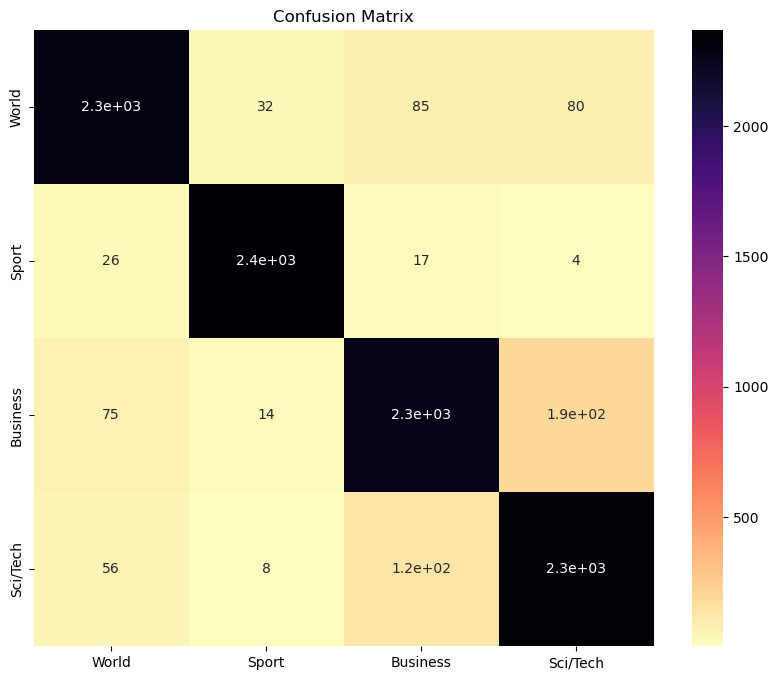

In [32]:
plt.figure(figsize=(10,8))

# plot the heat map 
sns.heatmap(
    confusion_matrix(test_df['label'], preds_flat),
    annot=True,
    xticklabels=['World','Sport','Business','Sci/Tech'],
    yticklabels=['World','Sport','Business','Sci/Tech'],
    cmap=plt.cm.magma_r
)
plt.title('Confusion Matrix')
plt.show()

### 4.4 Test model on random predictions

In [33]:
import random

In [34]:
num=random.randint(0,len(test_df)-101)
tokenized_test = pipeline(test_df[num:num+100]).remove_columns('label')

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [35]:
# accuracy on random 100 samples from test dataset: 99% which is great!
preds=trainer.predict(tokenized_test)
preds_flat = [np.argmax(x) for x in preds[0]]
print(classification_report(test_df['label'][num:num+100], preds_flat))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        27
           1       1.00      1.00      1.00        18
           2       0.93      0.90      0.91        29
           3       0.89      0.92      0.91        26

    accuracy                           0.93       100
   macro avg       0.94      0.94      0.94       100
weighted avg       0.93      0.93      0.93       100



# 5. Load Model

In [13]:

model_path = "models"
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

In [14]:
df_test=pd.read_csv("test.csv")
df_test.head(2)

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."


In [15]:
df_test['Text']=df_test['Title']+' '+df_test['Description']

df_test.drop(columns=['Title','Description'],axis=1,inplace=True)

df_test = df_test.rename(columns={'Class Index':'label'})


In [16]:
import re
def remove_punctuation(text):
    text=re.sub(r'[\\-]',' ',text)
    text=re.sub(r'[,.?;:\'(){}!|0-9]','',text)
    return text

In [17]:
df_test['Text']=df_test['Text'].apply(remove_punctuation)
df_test['label']=df_test['label']-1

In [18]:
df_test.head(2)

,label,Text
0,2,Fears for T N pension after talks Unions repre...
1,3,The Race is On Second Private Team Sets Launch...


In [19]:
# Tokenize the test data
tokenized_inputs = tokenizer(list(df_test['Text']), padding=True, truncation=True, return_tensors="pt")

# Convert the labels to PyTorch tensors
labels = torch.tensor(list(df_test['label']))



In [20]:
# Set the model to evaluation mode
model.eval()



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Making predictions on the test data
with torch.no_grad():
    outputs = model(**tokenized_inputs)

# Get the predicted probabilities and predicted labels
probs = softmax(outputs.logits, dim=1)
predicted_labels = torch.argmax(probs, dim=1).tolist()

# Print predicted label
print(predicted_labels)

In [ ]:
from sklearn.metrics import classification_report

# Convert the labels to a list
true_labels = list(df_test['label'])

# Print the classification report
print(classification_report(true_labels, predictions))